In [1]:
## first of all importing the secret variables
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
api_key = os.getenv("OPENAI_API_KEY")


In [2]:
## ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo",api_key=api_key)
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [4]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000022E0699AAD0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000022E069BCBE0>, root_client=<openai.OpenAI object at 0x0000022E02C0E8C0>, root_async_client=<openai.AsyncOpenAI object at 0x0000022E0699AB30>, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [5]:
llm.invoke("what is Data Science").content

'Data science is a multidisciplinary field that uses various scientific methods, processes, algorithms, and systems to extract knowledge and insights from structured and unstructured data. It combines elements of statistics, computer science, machine learning, and domain expertise to analyze and interpret complex data sets. Data scientists use a combination of programming languages, data visualization tools, and analytical techniques to uncover patterns, trends, and correlations in data that can be used to make informed business decisions, drive research, and solve complex problems.'

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter ## for splitting the text into chunks
from langchain_community.document_loaders import WebBaseLoader ## for loading the text from website
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
docs = [WebBaseLoader(url).load() for url in urls]
## my content is in nested list
## but i want my content in single list only
docs_list = [item for sublist in docs for item in sublist]
## i have my content in a single list
## now my next job is to split this text into chunks
## first of all i will be creating the RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 200,chunk_overlap = 100
)
docs_split = text_splitter.split_documents(docs_list)
## now i have my content in form of chunks
## now i will be converting these chunks into word vector embeddings
## and will store in a vector database
vectorstore = Chroma.from_documents(
    documents=docs_split,
    embedding=embeddings,
    collection_name="rag-chroma"
)
## creating retriever on top of this retriever
retriever = vectorstore.as_retriever()


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
## creating the tool of this retriever
from langchain.tools.retriever import create_retriever_tool
tool = create_retriever_tool(retriever,
                             "retrieve_blog_posts",
                             "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs",)
tools = [tool]

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field
## i want to create a system which will take two variables as the input
# question and documents, and using thinking capability of llm 
## we will decide either the question is related to documents or not
## now the main thing is in output
## if the question is related to documents
## then we will get binary_score = 'yes'
## otherwise we will get binary_score = 'no' 
## we want our output in this format only

c:\Users\Global\self_rag2\venv\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
class GradeDocuments(BaseModel):
    "Relevance score 'yes' or 'no'" 
    binary_score:str = Field(
        description = "Documents are relevant to the question 'yes' or 'no'"
    )

In [10]:
llm_with_structured_output = llm.with_structured_output(GradeDocuments)
system = """ You are a document grader.Given the question and given to you.
your job is to find out either these documents are relevant to question or not.
if the question is relevant to documents return binary_score = 'yes' 
and if the question is not relevant to documents then return binary_score = 'no'
                                """  
prompt = ChatPromptTemplate.from_messages(
[
    ("system",system),
    ("human","documents:{documents} \n question:{question}")
]
)
document_grader = prompt | llm_with_structured_output

In [11]:
question = "what is prompt engineering"
docs = retriever.invoke(question)
document_grader.invoke({"documents":docs,"question":question}).binary_score

'yes'

In [12]:
question = "what are AI agents" 
document_grader.invoke({"documents":docs,"question":question}).binary_score


'yes'

In [13]:
## now i will be creating the RAG chain
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
prompt = hub.pull("rlm/rag-prompt")
prompt ## this prompt is sepcifically designed for rag where question and doc is given
## and output is generated using that questiona and docs

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [14]:
question = "what is memory in agent" 
context = retriever.invoke(question)

In [15]:
rag_chain = prompt | llm
rag_chain.invoke({"question":question,"context":context})


AIMessage(content="In an agent system, memory consists of both short-term and long-term memory. Short-term memory is used for in-context learning, while long-term memory enables infinite information retention and recall over extended periods. Memory retrieval and reflection mechanisms help synthesize past experiences into inferences and guide the agent's future behavior.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 2278, 'total_tokens': 2340, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0194a94a-d693-4408-a63e-c2194f4cb6ca-0', usage_metadata={'input_tokens': 2278, 'output_tokens': 62, 'total_tokens': 2340, 'input_token_details': {'audio': 0, 'c

In [ ]:
## here i will be creating a system which take question and generation as input
## and will tell us either this generation is related to question or not
## main thing is if we question is related to documents
## then we will get binary_score = 'yes' in output
## and if the question is not related to documents
## then we will get binary_score = 'no' in output

In [16]:
## formatting the output of the system 
## that i want my output in this format only
class GradeQuestion(BaseModel):
    "Grades question with documents" 
    binary_score:str = Field(
        description ="Relevance score 'yes' or 'no' "
    )
llm_with_structured = llm.with_structured_output(GradeQuestion)
system="""an Intelligent AI system.Given the question and generation to you.
with your intelligence you need to find out either this question is related to this generation or not.
if the question is related to the generation return binary_score = 'yes'
and if the question is not related to generation then return binary_score = 'no'
                  
                            """
prompt = ChatPromptTemplate.from_messages(
    [("system",system),
     ("human","question:{question} \n generation:{generation} ")]
)

answer_grader = prompt | llm_with_structured


In [17]:
class HallucinationGrader(BaseModel):
    "Grades documents with generation" 
    binary_score:str = Field(
        description = "Relevance score 'yes' or 'no' "
    )
llm_with_structured_output = llm.with_structured_output(HallucinationGrader)


In [18]:
system = """   You are an intelligent AI system. Given the generation and documents to you.
your job is to find out that the documents are related to generation or not.
if the documents are related to generation then return binary_score = 'yes' 
and if the documents are not related to generation then return binary_score = 'no'
observe clearly then give any response.before giving binary_score = 'yes' or 'no' 
think properly.

 """  
prompt = ChatPromptTemplate.from_messages(
    [("system",system),
     ("human","documents:{documents} \n generation:{generation}")]
)

hallucination_grader = prompt | llm_with_structured_output

In [19]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [20]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [21]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.  
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)
hallucinations_grader = hallucination_prompt | structured_llm_grader

In [22]:

system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval.    
Note this thing if you find question is not releated to documents then in that case just return "question not relevant"
DO not give the explaination if the question is not relevant to documents
      

         """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [23]:
## defining the state of the function
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question:str
    generation:str
    documents:List[str]
    filter_documents:List[str]
    unfilter_documents:List[str]


In [24]:
## first of all creating the retrieve function
## this function will take user question as input and will return retrieved documents a soutput from the retriever
def retrieve(state:AgentState):
    question = state.get("question",None)
    if question is None:
        print("question not found")
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}
 
            

In [25]:
def grade_document(state:AgentState):
    question = state["question"] ## question
    documents = state["documents"] 
    filtered_docs = [] ## all the filtered documents will be stored in this list only
    unfiltered_docs = [] ## all the unfiltered documents will be stored in this list only

    for doc in documents:
        binary_score = document_grader.invoke({"question":question,"documents":doc}).binary_score
        if binary_score == 'yes':
            filtered_docs.append(doc)
        elif binary_score == 'no':
            unfiltered_docs.append(doc)
    ## now i have both filtered_doc and unfiltered_doc
    ## now if there is any unfiltered doc i will not return any filtered doc
    if len(unfiltered_docs) >1:
        return {"question":question,"documents":documents,"unfiltered_documents":unfiltered_docs,"filtered_documents":[]} ## in this case i am getting binary_score=no for any document
    else:
        return {"question":question,"documents":documents,"unfiltered_documents":[],"filtered_documents":filtered_docs} ## here i am not getting binary_score = 'no' for any document
    


In [26]:
def decide_to_generate(state:AgentState):
    question = state["question"]
    documents = state["documents"]
    unfiltered_documents = state["unfiltered_documents"]
    filtered_documents = state["filtered_documents"]
    
    ## taking the condition where there are some documents whose binary_score was no
    if unfiltered_documents:
        return "transform_query" 
    if filtered_documents:
        return "generate"                   

In [27]:
rag_chain

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000022E0699AAD0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000022E069BCBE0>, root_client=<openai.OpenAI object at 0x0000022E02C0E8C0>, root_as

In [35]:
def generate(state:AgentState):
    question = state["question"]
    documents = state["documents"]
    response = rag_chain.invoke({"question":question,"context":documents})
    return {"question":question,"documents":documents,"generation":response}

In [48]:
## suppose we went to first case
## now we need to rewrite the query based on the previous query intent and retrieved documents context
def transform_query(state:AgentState):
    question = state["question"]
    documents = state["documents"]
   

    question = question_rewriter.invoke({"question":question,"documents":document_grader})
    ## we passed the user question to question rewriter
    ## now there are two possibilities
    ## first possibility is that we will get the new generated question
    if question == 'question not relevant': ## if this case arises we will move to end and we also need to give generation
        return {"question":question,"documents":documents,"generation":"question not at all relevant"}
    else:
        return {"question":question,"documents":documents}
    

In [30]:
## after transform_query there are two possiblities 
## either we will go to end if question is not relevant 
## or we will again go to retriever part then follow the same process
def decide_to_generate_after_transform(state:AgentState):
    question = state["question"]
    if question == 'question not relevant':
        return "query_not_at_all_relevant" 
    else:
        return "Retriever"  


In [ ]:
## now comes the main function
## this function will be used afetr generation
## at this point of time we will have generation
## we will see if  generation is reated to retrieved documents or not
## and we will also see if the generation is related to user asked question or not
## in several cases it may also happen llm is generating the respons eon its own
## we need to find out this thing

In [31]:
def grade_generation_vs_documents_and_question(state:AgentState):
    question = state["question"] ## user question
    documents = state["documents"] ## retrieved documents
    generation = state["generation"] ## generation

    binary_score = hallucination_grader.invoke({"documents":documents,"generation":generation}).binary_score
    if binary_score == 'yes':
        binary_score = answer_grader.invoke({"generation":generation,"question":question}).binary_score
        if binary_score == 'yes':
            return 'useful' 
        else:
            return 'not useful' 
    else:
        return 'not useful' 

In [49]:
from langgraph.graph import StateGraph,END,START
workflow = StateGraph(AgentState)
workflow.add_node("retriever",retrieve)
workflow.add_node("grade_document",grade_document)
workflow.add_node("generate",generate)
workflow.add_node("transform_query",transform_query)

workflow.add_edge(START,"retriever")
workflow.add_edge("retriever","grade_document")
workflow.add_conditional_edges("grade_document",
                               decide_to_generate,
                               {"transform_query":"transform_query",
                                "generate":"generate"})
workflow.add_conditional_edges("generate",
                               grade_generation_vs_documents_and_question,
                               {"useful":END,
                                "not useful":'transform_query'})
workflow.add_conditional_edges("transform_query",
                               decide_to_generate_after_transform,
                               {"query_not_at_all_relevant":END,
                                "Retriever":"retriever"})

app = workflow.compile()


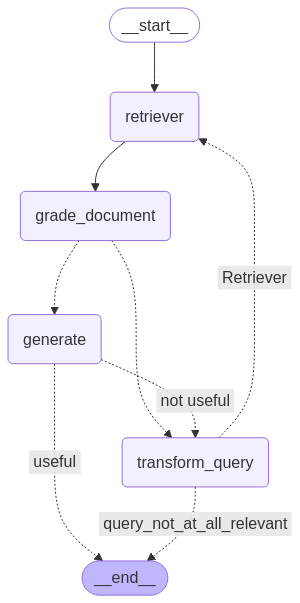

In [44]:
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
##  i have created the architecture
inputs = {"question": "Explain how the different types of agent memory work?"}
app.invoke(inputs)["generation"]

AIMessage(content="Short-term memory is utilized for in-context learning of the model. Long-term memory allows the agent to retain and recall information over extended periods. Memory stream records agents' experiences in natural language for retrieval.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 2240, 'total_tokens': 2281, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bedf328d-557d-4175-8350-06890cfc28b9-0', usage_metadata={'input_tokens': 2240, 'output_tokens': 41, 'total_tokens': 2281, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [52]:
inputs = {"question": "what is prompt engineering?"}
app.invoke(inputs)["generation"]

AIMessage(content='Prompt engineering, also known as In-Context Prompting, involves methods to communicate with language models without updating their weights to steer their behavior. It is an empirical science that varies in effectiveness among models, requiring extensive experimentation and heuristics. Prompt engineering focuses on alignment and model steerability specifically for autoregressive language models.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 1433, 'total_tokens': 1499, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-5cbb4dcc-5545-4139-8e1c-68b95834c455-0', usage_metadata={'input_tokens': 1433, 'output_tokens': 66, 'total_tokens': 

In [50]:
inputs = {"question": "who built Taj Mahal?"}
app.invoke(inputs)["generation"]

'question not at all relevant'